# HW 1


In [17]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import numpy as np
import pandas as pd
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
import re


In [19]:
file_path = '/content/drive/MyDrive/DSCI599/Datasets/AirBnB Data/Combined Listing Data [Summary].csv'
df = pd.read_csv(file_path)


<ipython-input-19-9beb813be4ce>:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


## Preprocess

This part aimed at identifying the most significant neighborhoods in a dataset based on their listing counts. Firstly, it counts the number of listings in each neighborhood, providing insight into neighborhood popularity. Then, it determines what constitutes the top 20% of all listings in the dataset. This threshold is used to identify key neighborhoods that cumulatively make up this top segment. By isolating these top neighborhoods, the analysis can focus on areas with the highest concentration of listings, which is beneficial for understanding market trends, targeting marketing efforts, or allocating resources more efficiently in those areas. The code also identifies the first neighborhood that exceeds the 20% threshold, adding further detail to the analysis.

In [20]:
# Count the number of listings in each neighbourhood
neighbourhood_counts = df['neighbourhood'].value_counts()

# In order to narrow down our research scope, we calculate the first 20% of the entire data set
top_20_percent_cutoff = int(len(df) * 0.2)

# Then, we need to find the neighborhood that cumulatively reaches this 20% threshold
cumulative_counts = neighbourhood_counts.cumsum()

top_20_percent_neighbourhoods = cumulative_counts[cumulative_counts <= top_20_percent_cutoff].index.tolist()


# Find the first neighborhood that exceeds a threshold equal to 20%

neighbourhood_list = neighbourhood_counts.index.tolist()
first_neighbourhood_above_20_percent = cumulative_counts[cumulative_counts > top_20_percent_cutoff].index[0]

# Find the index for this neighborhood
first_neighbourhood_index = neighbourhood_list.index(first_neighbourhood_above_20_percent)

# Add next neighborhood to list
next_neighbourhood = cumulative_counts.index[first_neighbourhood_index]
top_20_percent_neighbourhoods.append(next_neighbourhood)

print("We will focus on:", top_20_percent_neighbourhoods)


We will focus on: ['Venice', 'Hollywood', 'Long Beach', 'Downtown', 'Santa Monica']


Because our requirement is to analyze the impact of the Covid, we mainly analyze the data before and after the epidemic, that is, in 2019 and 2020.

In [21]:
# Filter out rows where the 'Scrape File' column does not contain '2019', '2020'
df = df[df['Scrape File'].str.contains('2019|2020')]

# Reset the index to ensure it is contiguous
df.reset_index(drop=True, inplace=True)

## Price Analysis

### Venice

This code is focusing on rental prices for entire homes or apartments in Venice for the years 2019 and 2020. It begins by preparing the data, extracting necessary information, and filtering for the relevant neighborhood and property type. The script then employs the Interquartile Range method to remove price outliers, ensuring a more accurate analysis. It splits the data by year, aggregates monthly prices, and creates boxplots to visually represent price distributions. Additionally, it calculates and plots median prices, providing clear insights into monthly price trends. The final visualization is a detailed plot comparing these trends across the two years, offering a nuanced understanding of market dynamics in a specific area.


<ipython-input-27-87faee87cc37>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2019['month'] = data_2019['year_month'].apply(lambda x: x.split('_')[1])
<ipython-input-27-87faee87cc37>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2020['month'] = data_2020['year_month'].apply(lambda x: x.split('_')[1])


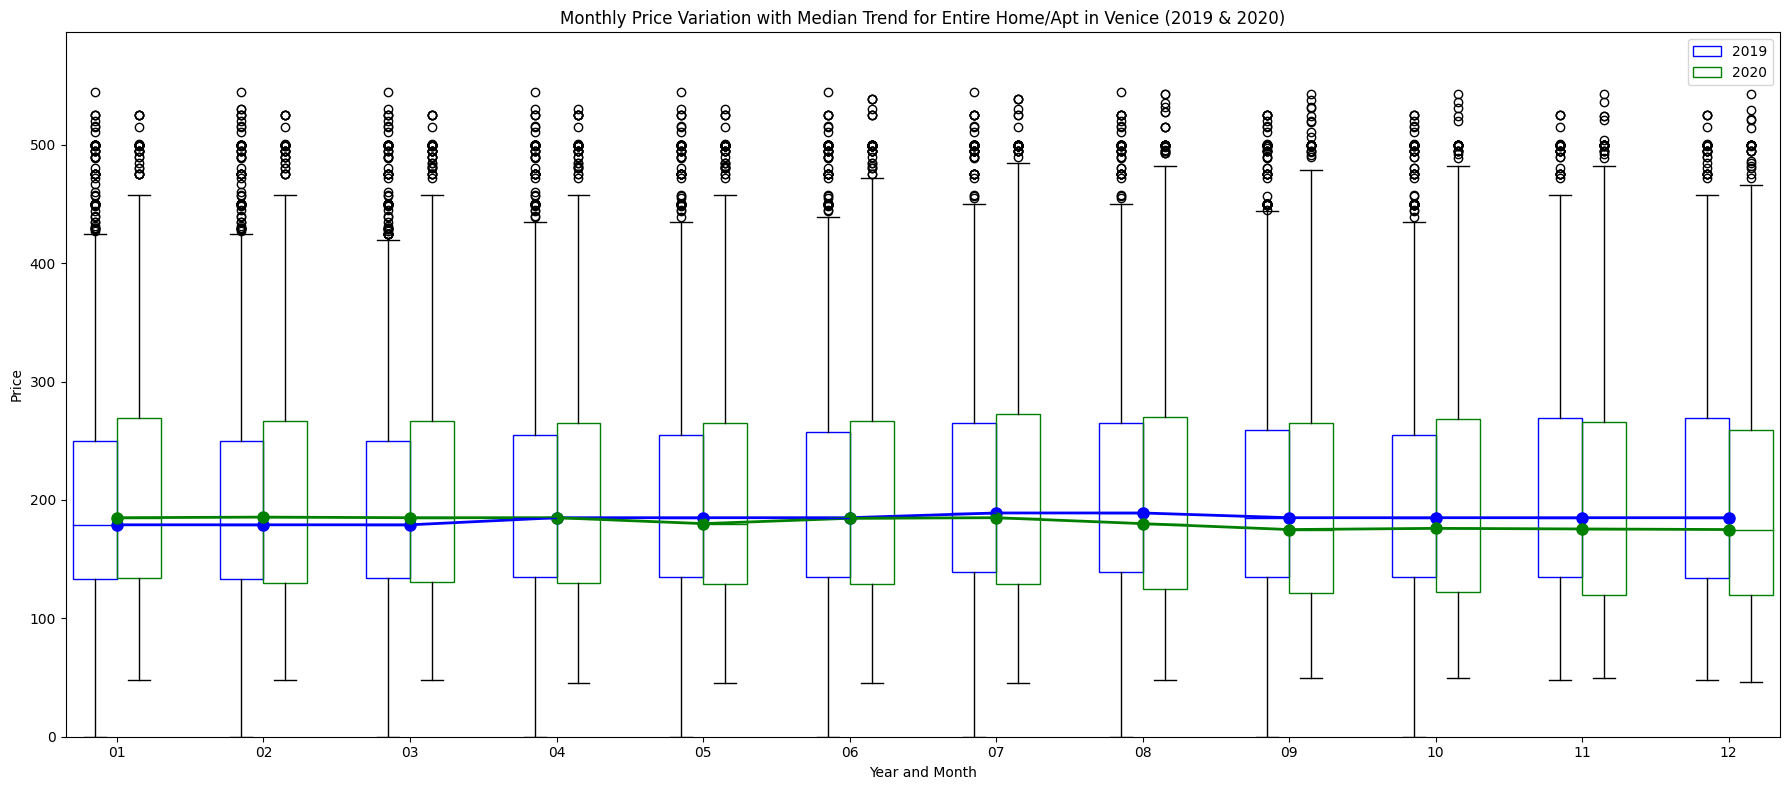

In [27]:

plt.figure(figsize=(18, 8))

# Extracting year and month from the 'Scrape File' column
df['year_month'] = df['Scrape File'].apply(lambda x: re.findall(r'\d{4}_\d{2}', x)[0])

# Filtering data for Venice area and Entire home/apt
venice_df = df[(df['neighbourhood'] == 'Venice') & (df['room_type'] == 'Entire home/apt')]

# Removing outliers using IQR method
Q1 = venice_df['price'].quantile(0.25)
Q3 = venice_df['price'].quantile(0.75)
IQR = Q3 - Q1

# Defining the limits for outliers
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Filtering out the outliers
venice_df = venice_df[(venice_df['price'] >= lower_limit) & (venice_df['price'] <= upper_limit)]

data_2019 = venice_df[venice_df['Scrape File'].str.contains('2019')]
data_2020 = venice_df[venice_df['Scrape File'].str.contains('2020')]

# Modify the year_month column so that it only contains month information, ensuring that the month labels are the same for 2019 and 2020
data_2019['month'] = data_2019['year_month'].apply(lambda x: x.split('_')[1])
data_2020['month'] = data_2020['year_month'].apply(lambda x: x.split('_')[1])

months = data_2019['month'].unique()
prices_2019 = [data_2019[data_2019['month'] == month]['price'] for month in months]
prices_2020 = [data_2020[data_2020['month'] == month]['price'] for month in months]

bp_2019 = plt.boxplot(prices_2019, positions=np.arange(len(months)) - 0.15, widths=0.3, patch_artist=True, boxprops=dict(facecolor='none', color='blue'), medianprops=dict(color='blue'))
bp_2020 = plt.boxplot(prices_2020, positions=np.arange(len(months)) + 0.15, widths=0.3, patch_artist=True, boxprops=dict(facecolor='none', color='green'), medianprops=dict(color='green'))

# Calculate monthly median price
median_prices_2019 = data_2019.groupby('year_month')['price'].median()
median_prices_2020 = data_2020.groupby('year_month')['price'].median()

median_prices_2019.index = median_prices_2019.index.str[5:]
median_prices_2020.index = median_prices_2020.index.str[5:]

plt.plot(median_prices_2019.index, median_prices_2019.values, color='blue', marker='o', linestyle='-', linewidth=2, markersize=8, label='Median - 2019')
plt.plot(median_prices_2020.index, median_prices_2020.values, color='green', marker='o', linestyle='-', linewidth=2, markersize=8, label='Median - 2020')

plt.xticks(np.arange(len(months)), months)
plt.title('Monthly Price Variation with Median Trend for Entire Home/Apt in Venice (2019 & 2020)')
plt.xlabel('Year and Month')
plt.ylabel('Price')
plt.ylim([0, max(venice_df['price']) + 50])
plt.legend([bp_2019["boxes"][0], bp_2020["boxes"][0]], ['2019', '2020'], loc='upper right')
plt.tight_layout()
plt.show()


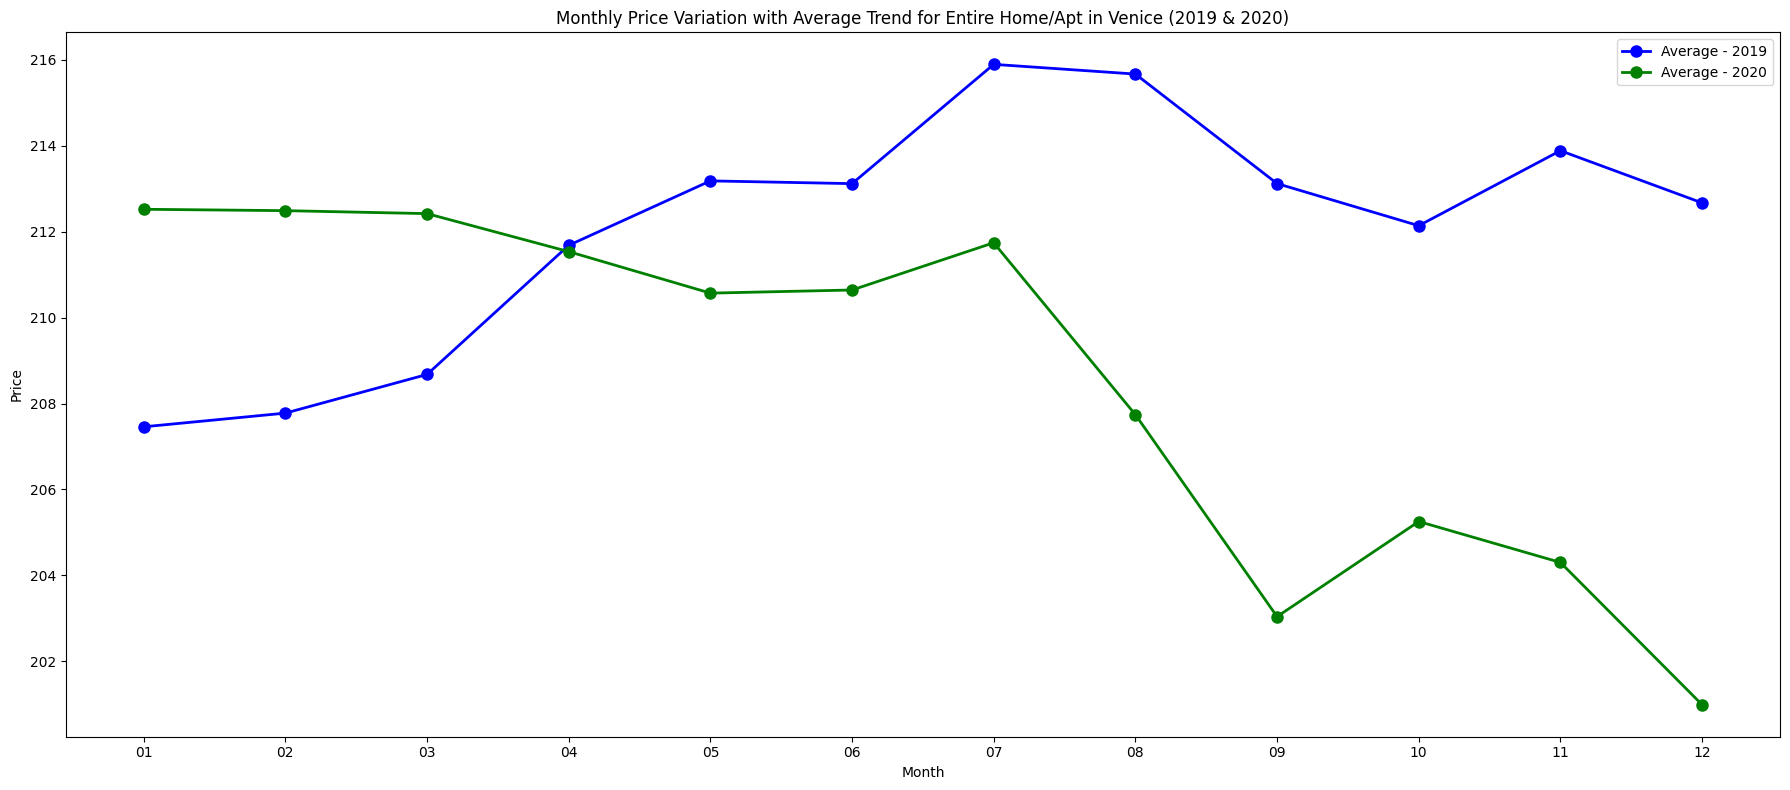

In [28]:
plt.figure(figsize=(18, 8))

# Calculate the monthly average price after excluding outliers and draw a line chart
average_prices_2019 = data_2019.groupby('month')['price'].mean()
average_prices_2020 = data_2020.groupby('month')['price'].mean()

plt.plot(np.arange(len(months)), average_prices_2019.values, color='blue', marker='o', linestyle='-', linewidth=2, markersize=8, label='Average - 2019')
plt.plot(np.arange(len(months)), average_prices_2020.values, color='green', marker='o', linestyle='-', linewidth=2, markersize=8, label='Average - 2020')

plt.xticks(np.arange(len(months)), months)
plt.title('Monthly Price Variation with Average Trend for Entire Home/Apt in Venice (2019 & 2020)')
plt.xlabel('Month')
plt.ylabel('Price')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

Based on the two graphs provided, we can infer some potential impacts of the COVID-19 pandemic on the AirBnB market.

The first graph, showing boxplots with median price trends, provides additional detail on the price distributions. In 2020, the median prices are closer to the lower end of the price range, and the interquartile ranges (the boxes) are generally smaller and lower than in 2019. This suggests a contraction in the price variability, with fewer high-priced outliers, which again could be due to a pandemic-driven decrease in demand, especially for higher-priced listings.

From the second graph, which plots average prices, we observe that in 2020 there is a significant drop in prices starting around March, which aligns with the global onset of the pandemic. The prices remain lower throughout the majority of the year compared to 2019, indicating that the pandemic likely led to a decrease in demand, which in turn may have caused hosts to lower prices to attract guests.

The consistent trend across both graphs suggests that the pandemic has had a cooling effect on the AirBnB market in Venice, with lower prices and reduced variability in 2020 compared to 2019. This could be due to various factors such as travel restrictions, economic uncertainty, and changing travel preferences due to health concerns.

### Hollywood

<ipython-input-32-17b9a2e994e6>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2019['month'] = data_2019['year_month'].apply(lambda x: x.split('_')[1])
<ipython-input-32-17b9a2e994e6>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2020['month'] = data_2020['year_month'].apply(lambda x: x.split('_')[1])


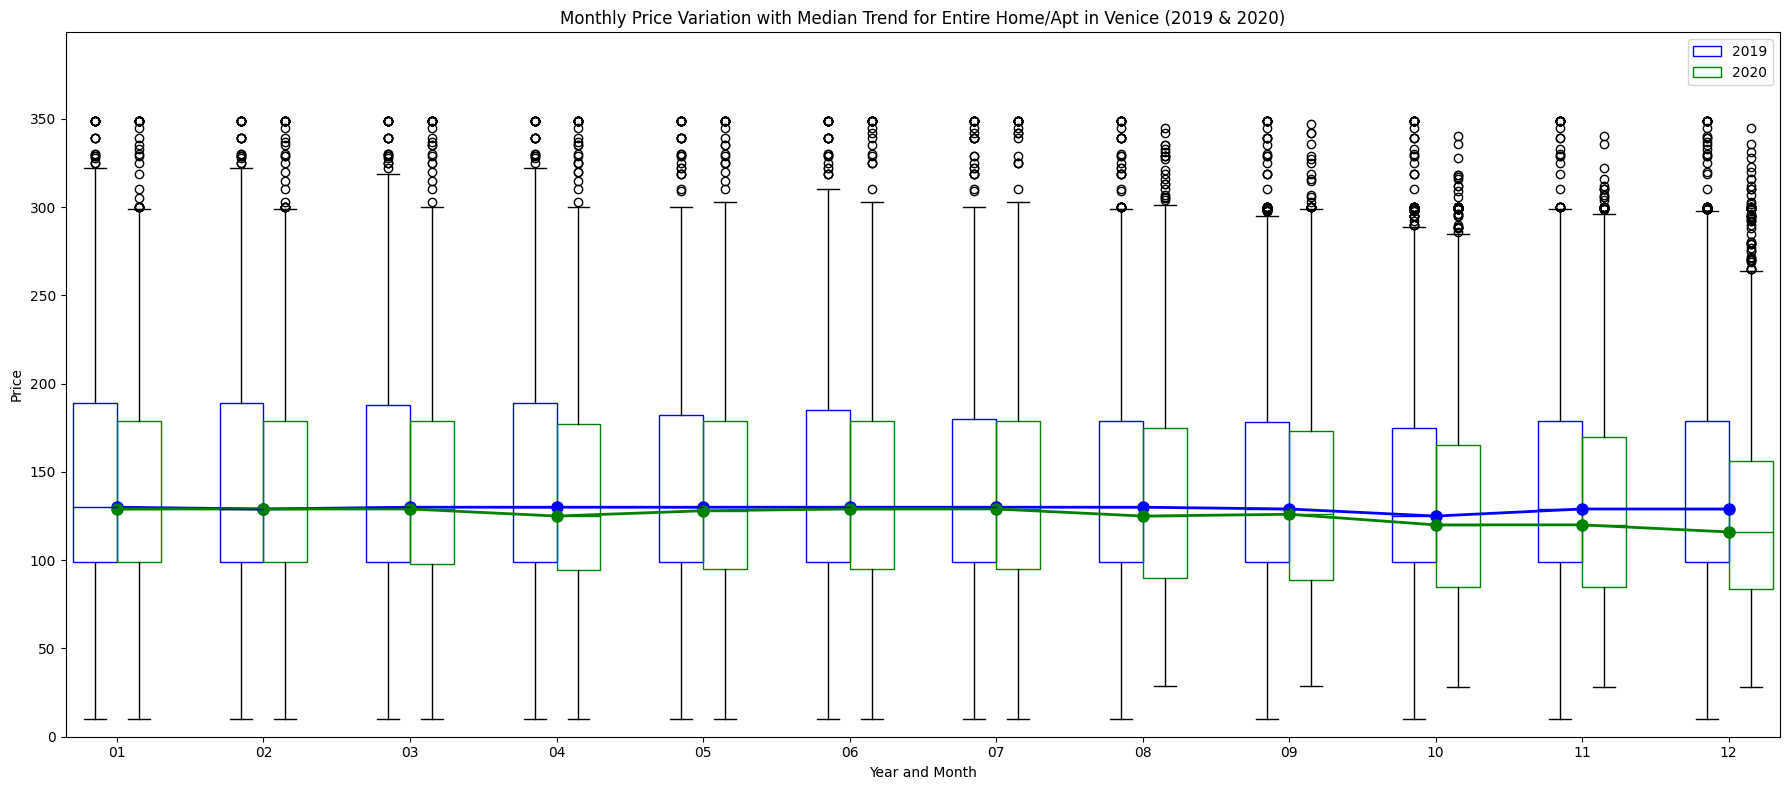

In [32]:

plt.figure(figsize=(18, 8))

# Extracting year and month from the 'Scrape File' column
df['year_month'] = df['Scrape File'].apply(lambda x: re.findall(r'\d{4}_\d{2}', x)[0])

# Filtering data for Venice area and Entire home/apt
hollywood_df = df[(df['neighbourhood'] == 'Hollywood') & (df['room_type'] == 'Entire home/apt')]

# Removing outliers using IQR method
Q1 = hollywood_df['price'].quantile(0.25)
Q3 = hollywood_df['price'].quantile(0.75)
IQR = Q3 - Q1

# Defining the limits for outliers
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Filtering out the outliers
hollywood_df = hollywood_df[(hollywood_df['price'] >= lower_limit) & (hollywood_df['price'] <= upper_limit)]

data_2019 = hollywood_df[hollywood_df['Scrape File'].str.contains('2019')]
data_2020 = hollywood_df[hollywood_df['Scrape File'].str.contains('2020')]

# Modify the year_month column so that it only contains month information, ensuring that the month labels are the same for 2019 and 2020
data_2019['month'] = data_2019['year_month'].apply(lambda x: x.split('_')[1])
data_2020['month'] = data_2020['year_month'].apply(lambda x: x.split('_')[1])

months = data_2019['month'].unique()
prices_2019 = [data_2019[data_2019['month'] == month]['price'] for month in months]
prices_2020 = [data_2020[data_2020['month'] == month]['price'] for month in months]

bp_2019 = plt.boxplot(prices_2019, positions=np.arange(len(months)) - 0.15, widths=0.3, patch_artist=True, boxprops=dict(facecolor='none', color='blue'), medianprops=dict(color='blue'))
bp_2020 = plt.boxplot(prices_2020, positions=np.arange(len(months)) + 0.15, widths=0.3, patch_artist=True, boxprops=dict(facecolor='none', color='green'), medianprops=dict(color='green'))

# Calculate monthly median price
median_prices_2019 = data_2019.groupby('year_month')['price'].median()
median_prices_2020 = data_2020.groupby('year_month')['price'].median()

median_prices_2019.index = median_prices_2019.index.str[5:]
median_prices_2020.index = median_prices_2020.index.str[5:]

plt.plot(median_prices_2019.index, median_prices_2019.values, color='blue', marker='o', linestyle='-', linewidth=2, markersize=8, label='Median - 2019')
plt.plot(median_prices_2020.index, median_prices_2020.values, color='green', marker='o', linestyle='-', linewidth=2, markersize=8, label='Median - 2020')

plt.xticks(np.arange(len(months)), months)
plt.title('Monthly Price Variation with Median Trend for Entire Home/Apt in Hollywood (2019 & 2020)')
plt.xlabel('Year and Month')
plt.ylabel('Price')
plt.ylim([0, max(hollywood_df['price']) + 50])
plt.legend([bp_2019["boxes"][0], bp_2020["boxes"][0]], ['2019', '2020'], loc='upper right')
plt.tight_layout()
plt.show()


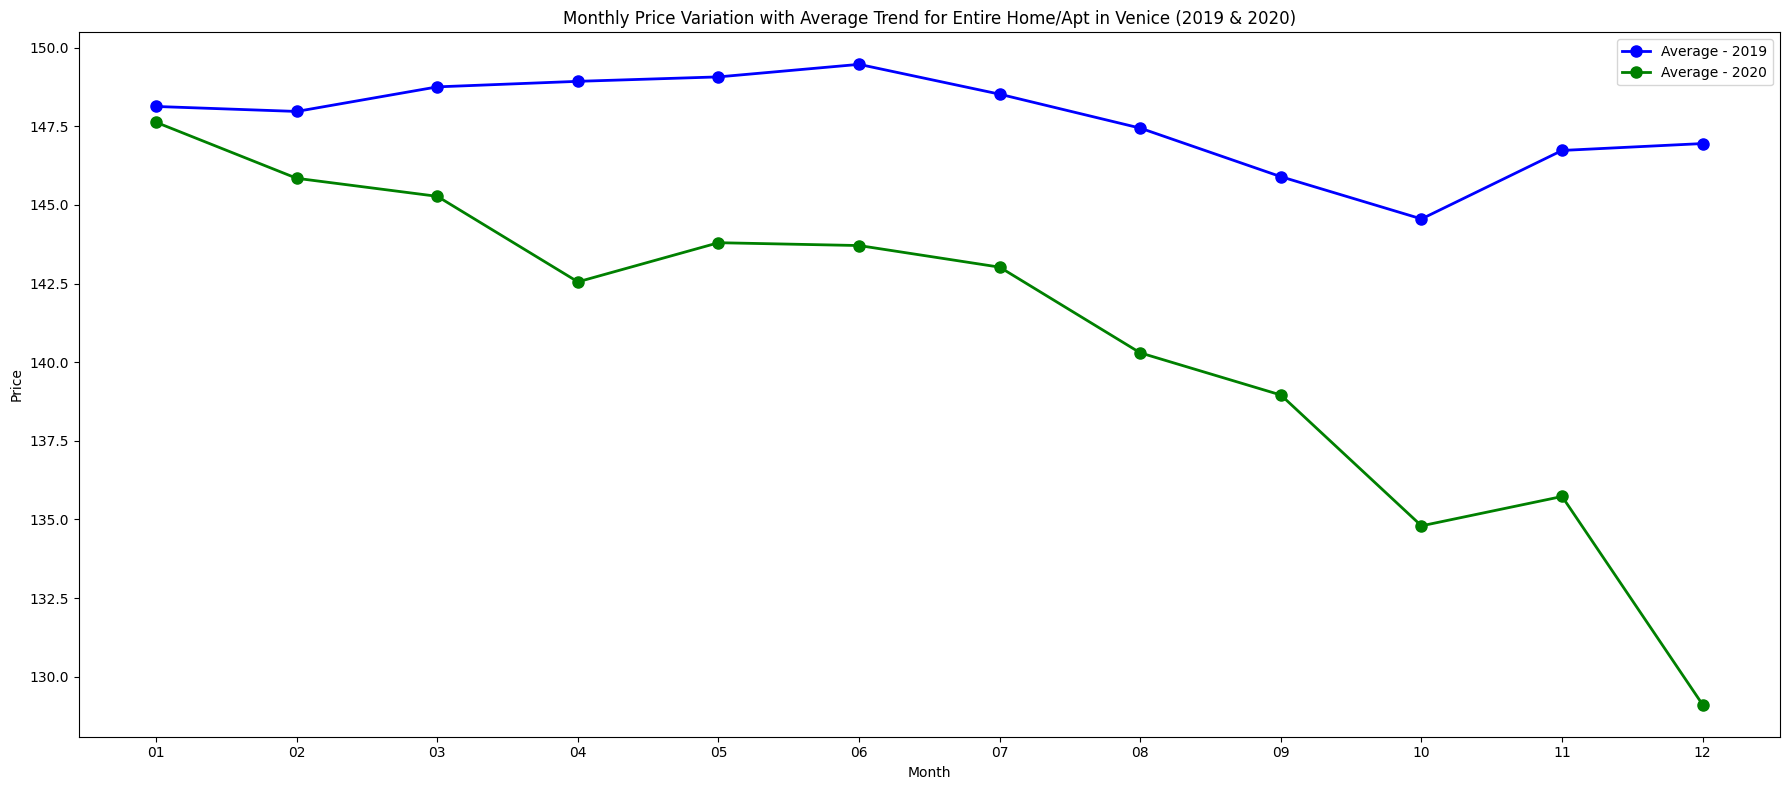

In [30]:
plt.figure(figsize=(18, 8))

# Calculate the monthly average price after excluding outliers and draw a line chart
average_prices_2019 = data_2019.groupby('month')['price'].mean()
average_prices_2020 = data_2020.groupby('month')['price'].mean()

plt.plot(np.arange(len(months)), average_prices_2019.values, color='blue', marker='o', linestyle='-', linewidth=2, markersize=8, label='Average - 2019')
plt.plot(np.arange(len(months)), average_prices_2020.values, color='green', marker='o', linestyle='-', linewidth=2, markersize=8, label='Average - 2020')

plt.xticks(np.arange(len(months)), months)
plt.title('Monthly Price Variation with Average Trend for Entire Home/Apt in Hollywood (2019 & 2020)')
plt.xlabel('Month')
plt.ylabel('Price')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

### Long Beach

<ipython-input-33-4b20b0686d90>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2019['month'] = data_2019['year_month'].apply(lambda x: x.split('_')[1])
<ipython-input-33-4b20b0686d90>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2020['month'] = data_2020['year_month'].apply(lambda x: x.split('_')[1])


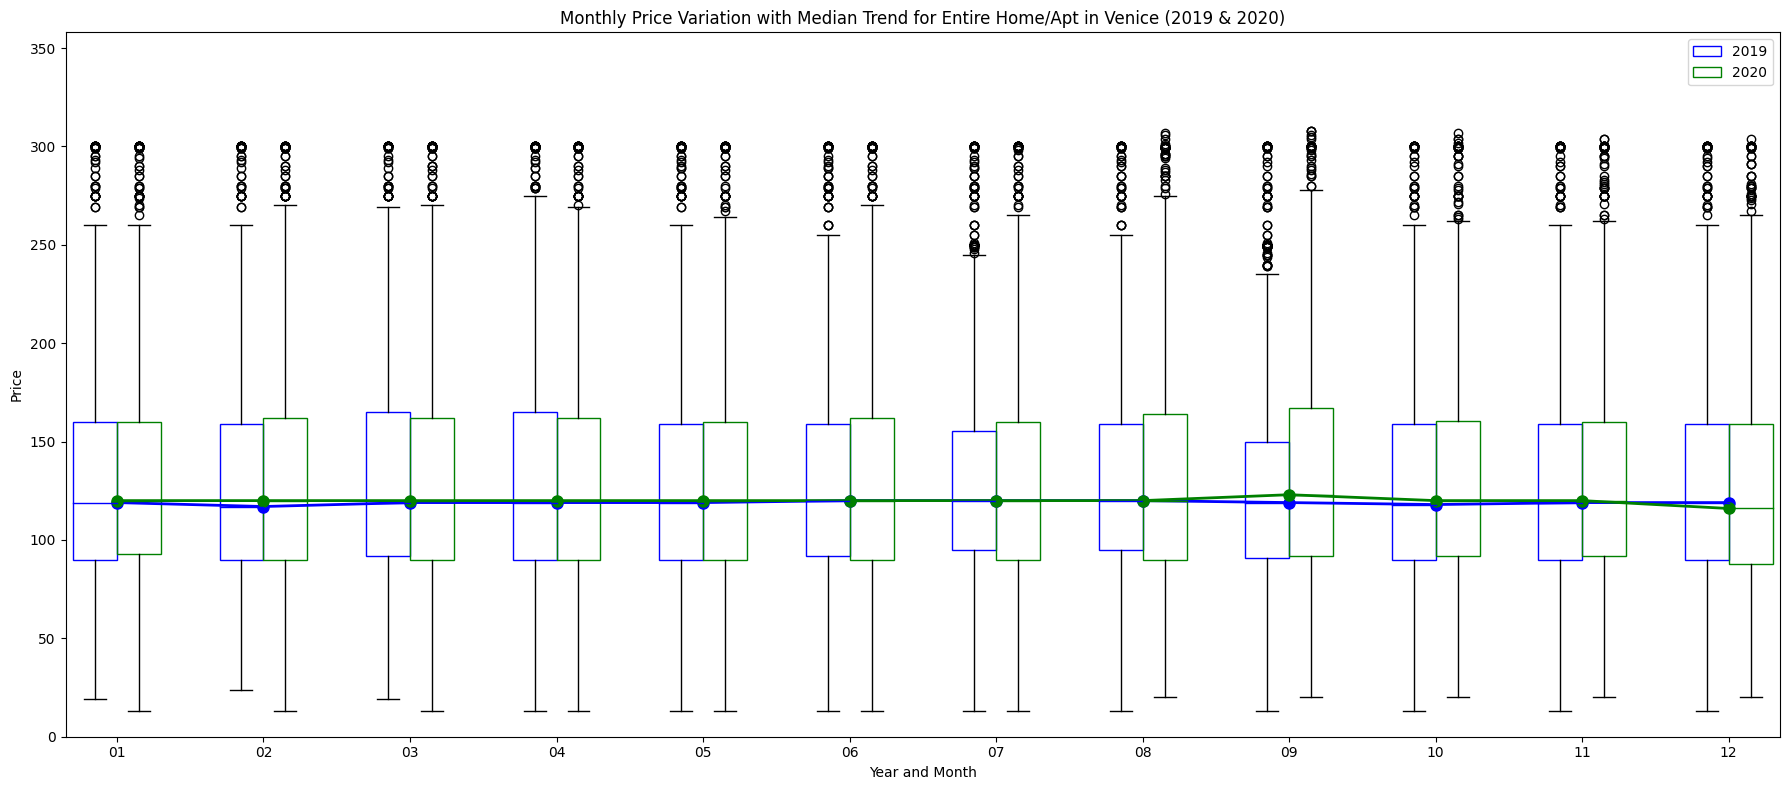

In [33]:

plt.figure(figsize=(18, 8))

# Extracting year and month from the 'Scrape File' column
df['year_month'] = df['Scrape File'].apply(lambda x: re.findall(r'\d{4}_\d{2}', x)[0])

# Filtering data for Venice area and Entire home/apt
longbeach_df = df[(df['neighbourhood'] == 'Long Beach') & (df['room_type'] == 'Entire home/apt')]

# Removing outliers using IQR method
Q1 = longbeach_df['price'].quantile(0.25)
Q3 = longbeach_df['price'].quantile(0.75)
IQR = Q3 - Q1

# Defining the limits for outliers
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Filtering out the outliers
longbeach_df = longbeach_df[(longbeach_df['price'] >= lower_limit) & (longbeach_df['price'] <= upper_limit)]

data_2019 = longbeach_df[longbeach_df['Scrape File'].str.contains('2019')]
data_2020 = longbeach_df[longbeach_df['Scrape File'].str.contains('2020')]

# Modify the year_month column so that it only contains month information, ensuring that the month labels are the same for 2019 and 2020
data_2019['month'] = data_2019['year_month'].apply(lambda x: x.split('_')[1])
data_2020['month'] = data_2020['year_month'].apply(lambda x: x.split('_')[1])

months = data_2019['month'].unique()
prices_2019 = [data_2019[data_2019['month'] == month]['price'] for month in months]
prices_2020 = [data_2020[data_2020['month'] == month]['price'] for month in months]

bp_2019 = plt.boxplot(prices_2019, positions=np.arange(len(months)) - 0.15, widths=0.3, patch_artist=True, boxprops=dict(facecolor='none', color='blue'), medianprops=dict(color='blue'))
bp_2020 = plt.boxplot(prices_2020, positions=np.arange(len(months)) + 0.15, widths=0.3, patch_artist=True, boxprops=dict(facecolor='none', color='green'), medianprops=dict(color='green'))

# Calculate monthly median price
median_prices_2019 = data_2019.groupby('year_month')['price'].median()
median_prices_2020 = data_2020.groupby('year_month')['price'].median()

median_prices_2019.index = median_prices_2019.index.str[5:]
median_prices_2020.index = median_prices_2020.index.str[5:]

plt.plot(median_prices_2019.index, median_prices_2019.values, color='blue', marker='o', linestyle='-', linewidth=2, markersize=8, label='Median - 2019')
plt.plot(median_prices_2020.index, median_prices_2020.values, color='green', marker='o', linestyle='-', linewidth=2, markersize=8, label='Median - 2020')

plt.xticks(np.arange(len(months)), months)
plt.title('Monthly Price Variation with Median Trend for Entire Home/Apt in Long Beach (2019 & 2020)')
plt.xlabel('Year and Month')
plt.ylabel('Price')
plt.ylim([0, max(longbeach_df['price']) + 50])
plt.legend([bp_2019["boxes"][0], bp_2020["boxes"][0]], ['2019', '2020'], loc='upper right')
plt.tight_layout()
plt.show()


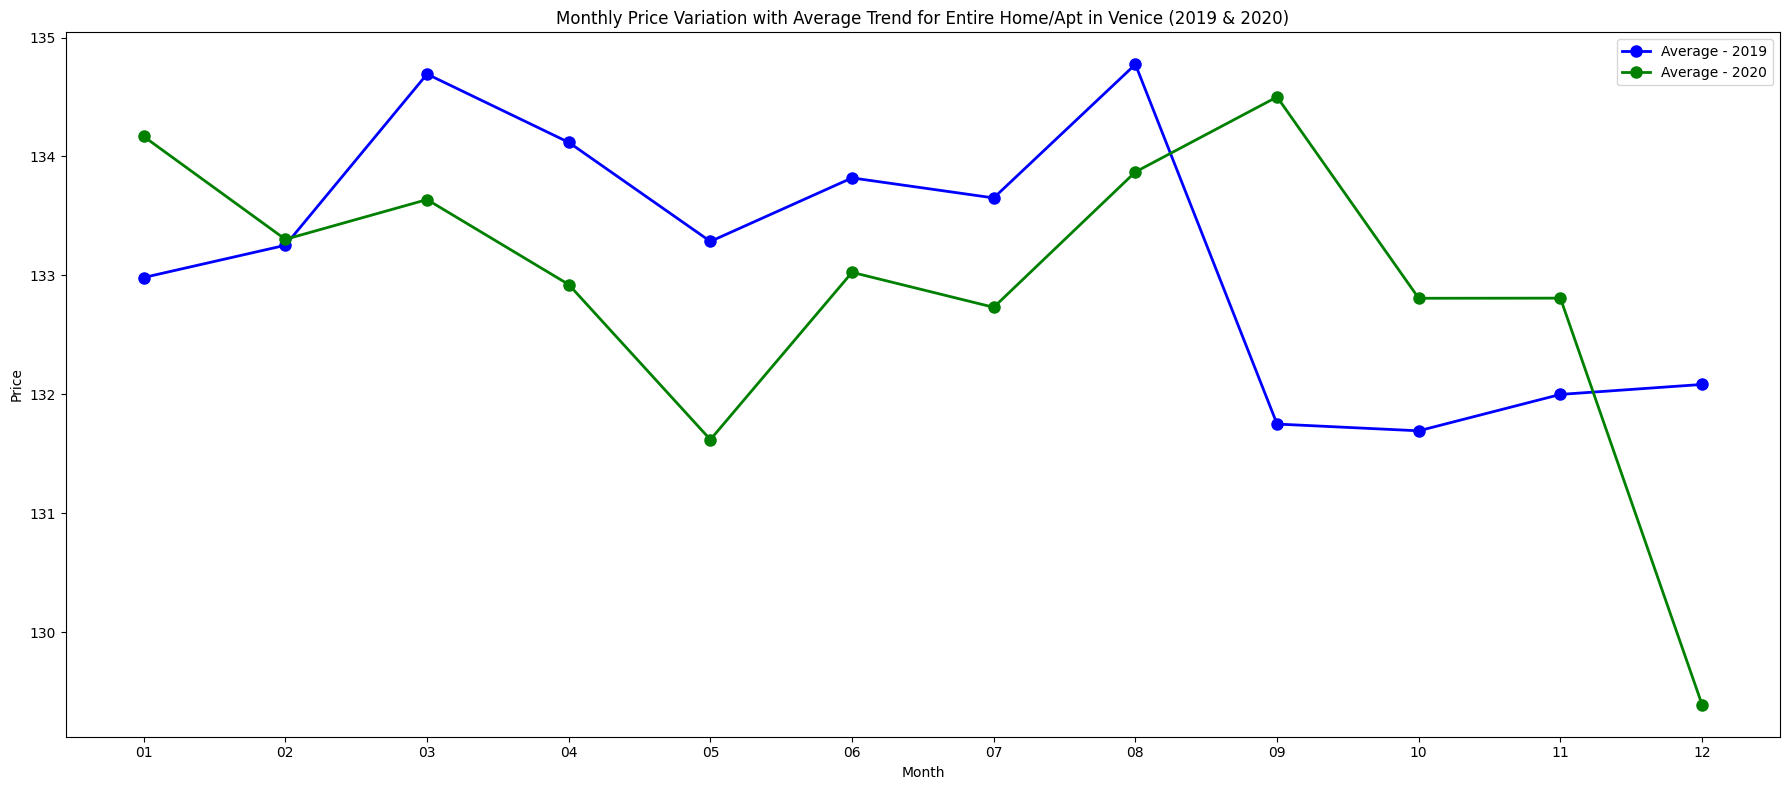

In [34]:
plt.figure(figsize=(18, 8))

# Calculate the monthly average price after excluding outliers and draw a line chart
average_prices_2019 = data_2019.groupby('month')['price'].mean()
average_prices_2020 = data_2020.groupby('month')['price'].mean()

plt.plot(np.arange(len(months)), average_prices_2019.values, color='blue', marker='o', linestyle='-', linewidth=2, markersize=8, label='Average - 2019')
plt.plot(np.arange(len(months)), average_prices_2020.values, color='green', marker='o', linestyle='-', linewidth=2, markersize=8, label='Average - 2020')

plt.xticks(np.arange(len(months)), months)
plt.title('Monthly Price Variation with Average Trend for Entire Home/Apt in Long Beach (2019 & 2020)')
plt.xlabel('Month')
plt.ylabel('Price')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

Similar results are provided by inspecting Hollywood and Long Beach.

## Availability Analysis

<ipython-input-35-564b23c8b867>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['year'] = filtered_df['Scrape File'].apply(lambda x: re.findall(r'\d{4}', x)[0])


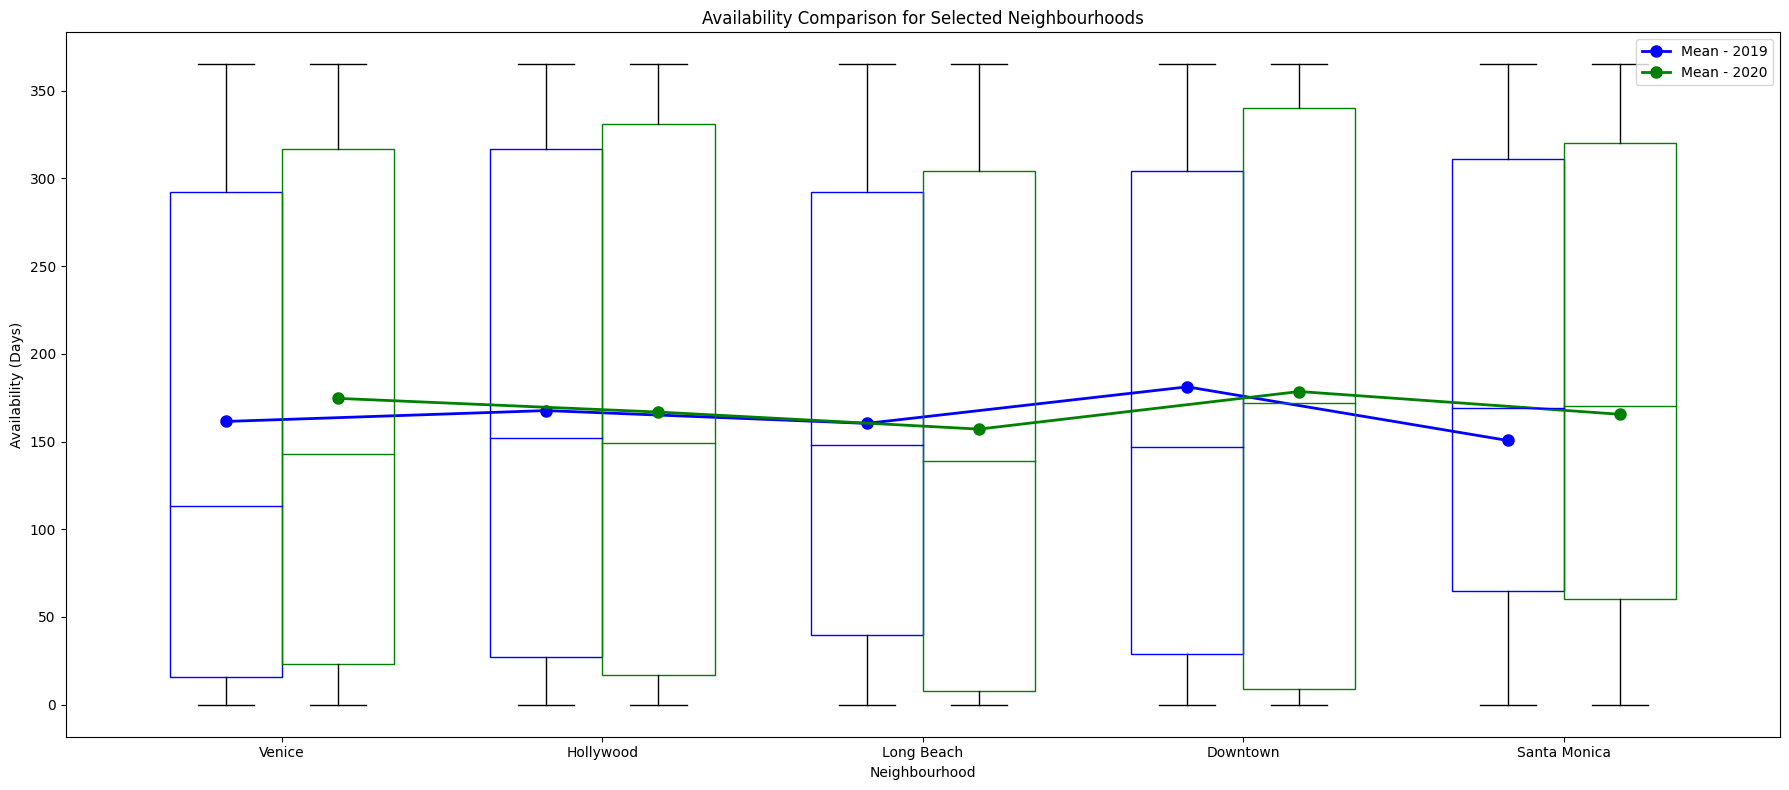

In [35]:


def prepare_and_plot_availability(df, neighbourhoods, years):
    # Filter the dataframe for the selected neighbourhoods
    filtered_df = df[df['neighbourhood'].isin(neighbourhoods)]

    # Extracting year from the 'Scrape File' column
    filtered_df['year'] = filtered_df['Scrape File'].apply(lambda x: re.findall(r'\d{4}', x)[0])

    plt.figure(figsize=(18, 8))

    for year in years:
        # Filter the data for the specific year
        data_year = filtered_df[filtered_df['year'] == year]

        # Calculate mean availability for line plot
        mean_availability = data_year.groupby('neighbourhood')['availability_365'].mean()

        # Prepare data for boxplot
        availability_data = data_year.groupby('neighbourhood')['availability_365'].apply(list)

        # Boxplot
        positions = np.arange(len(neighbourhoods))
        box_width = 0.35
        offset = (years.index(year) - 0.5) * box_width
        plt.boxplot([availability_data.get(n, []) for n in neighbourhoods], positions=positions + offset, widths=box_width, patch_artist=True, boxprops=dict(facecolor='none', color='blue' if year == '2019' else 'green'), medianprops=dict(color='blue' if year == '2019' else 'green'))

        # Line plot for mean availability
        plt.plot(positions + offset, mean_availability.values, color='blue' if year == '2019' else 'green', marker='o', linestyle='-', linewidth=2, markersize=8, label=f'Mean - {year}')

    # Setting the plot details
    plt.xticks(positions, neighbourhoods)
    plt.title('Availability Comparison for Selected Neighbourhoods')
    plt.xlabel('Neighbourhood')
    plt.ylabel('Availability (Days)')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# Example usage
neighbourhoods = ['Venice', 'Hollywood', 'Long Beach', 'Downtown', 'Santa Monica']
years = ['2019', '2020']

# Replace 'df' with your actual dataframe
prepare_and_plot_availability(df, neighbourhoods, years)


The boxplots for the year 2020 (green) generally show a higher median availability than those for 2019 (blue). This suggests that Airbnb listings were available for more days in 2020, indicating a potential decrease in demand. This is consistent with the travel restrictions and reduced tourism due to the pandemic.

The mean availability lines show a distinct shift from 2019 to 2020. For instance, the line for 2020 trends higher in most neighbourhoods compared to 2019, further supporting the idea of reduced bookings and longer available periods.


The interquartile ranges (the height of the boxes) and the whiskers (lines extending from the boxes) in 2020 are generally larger than those in 2019. This increased variability could be a result of the unpredictable travel patterns during the pandemic, with some properties seeing little to no bookings, while others might have been used for longer-term stays by individuals seeking alternative accommodations.


However, it's notable that the trend lines for both years cross over in the Downtown area, suggesting that the impact of the pandemic on Airbnb availability might have varied significantly by neighbourhood. This could reflect a resilience in the market demand for certain areas or could be influenced by other factors such as local restrictions, the appeal of the neighbourhood for longer-term stays, or changes in the resident demographics and their travel behaviour during the pandemic.

### Room Type Analysis

<ipython-input-40-f3d266f7a914>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_neighbourhoods['year'] = df_top_neighbourhoods['Scrape File'].apply(lambda x: re.findall(r'\d{4}', x)[0])


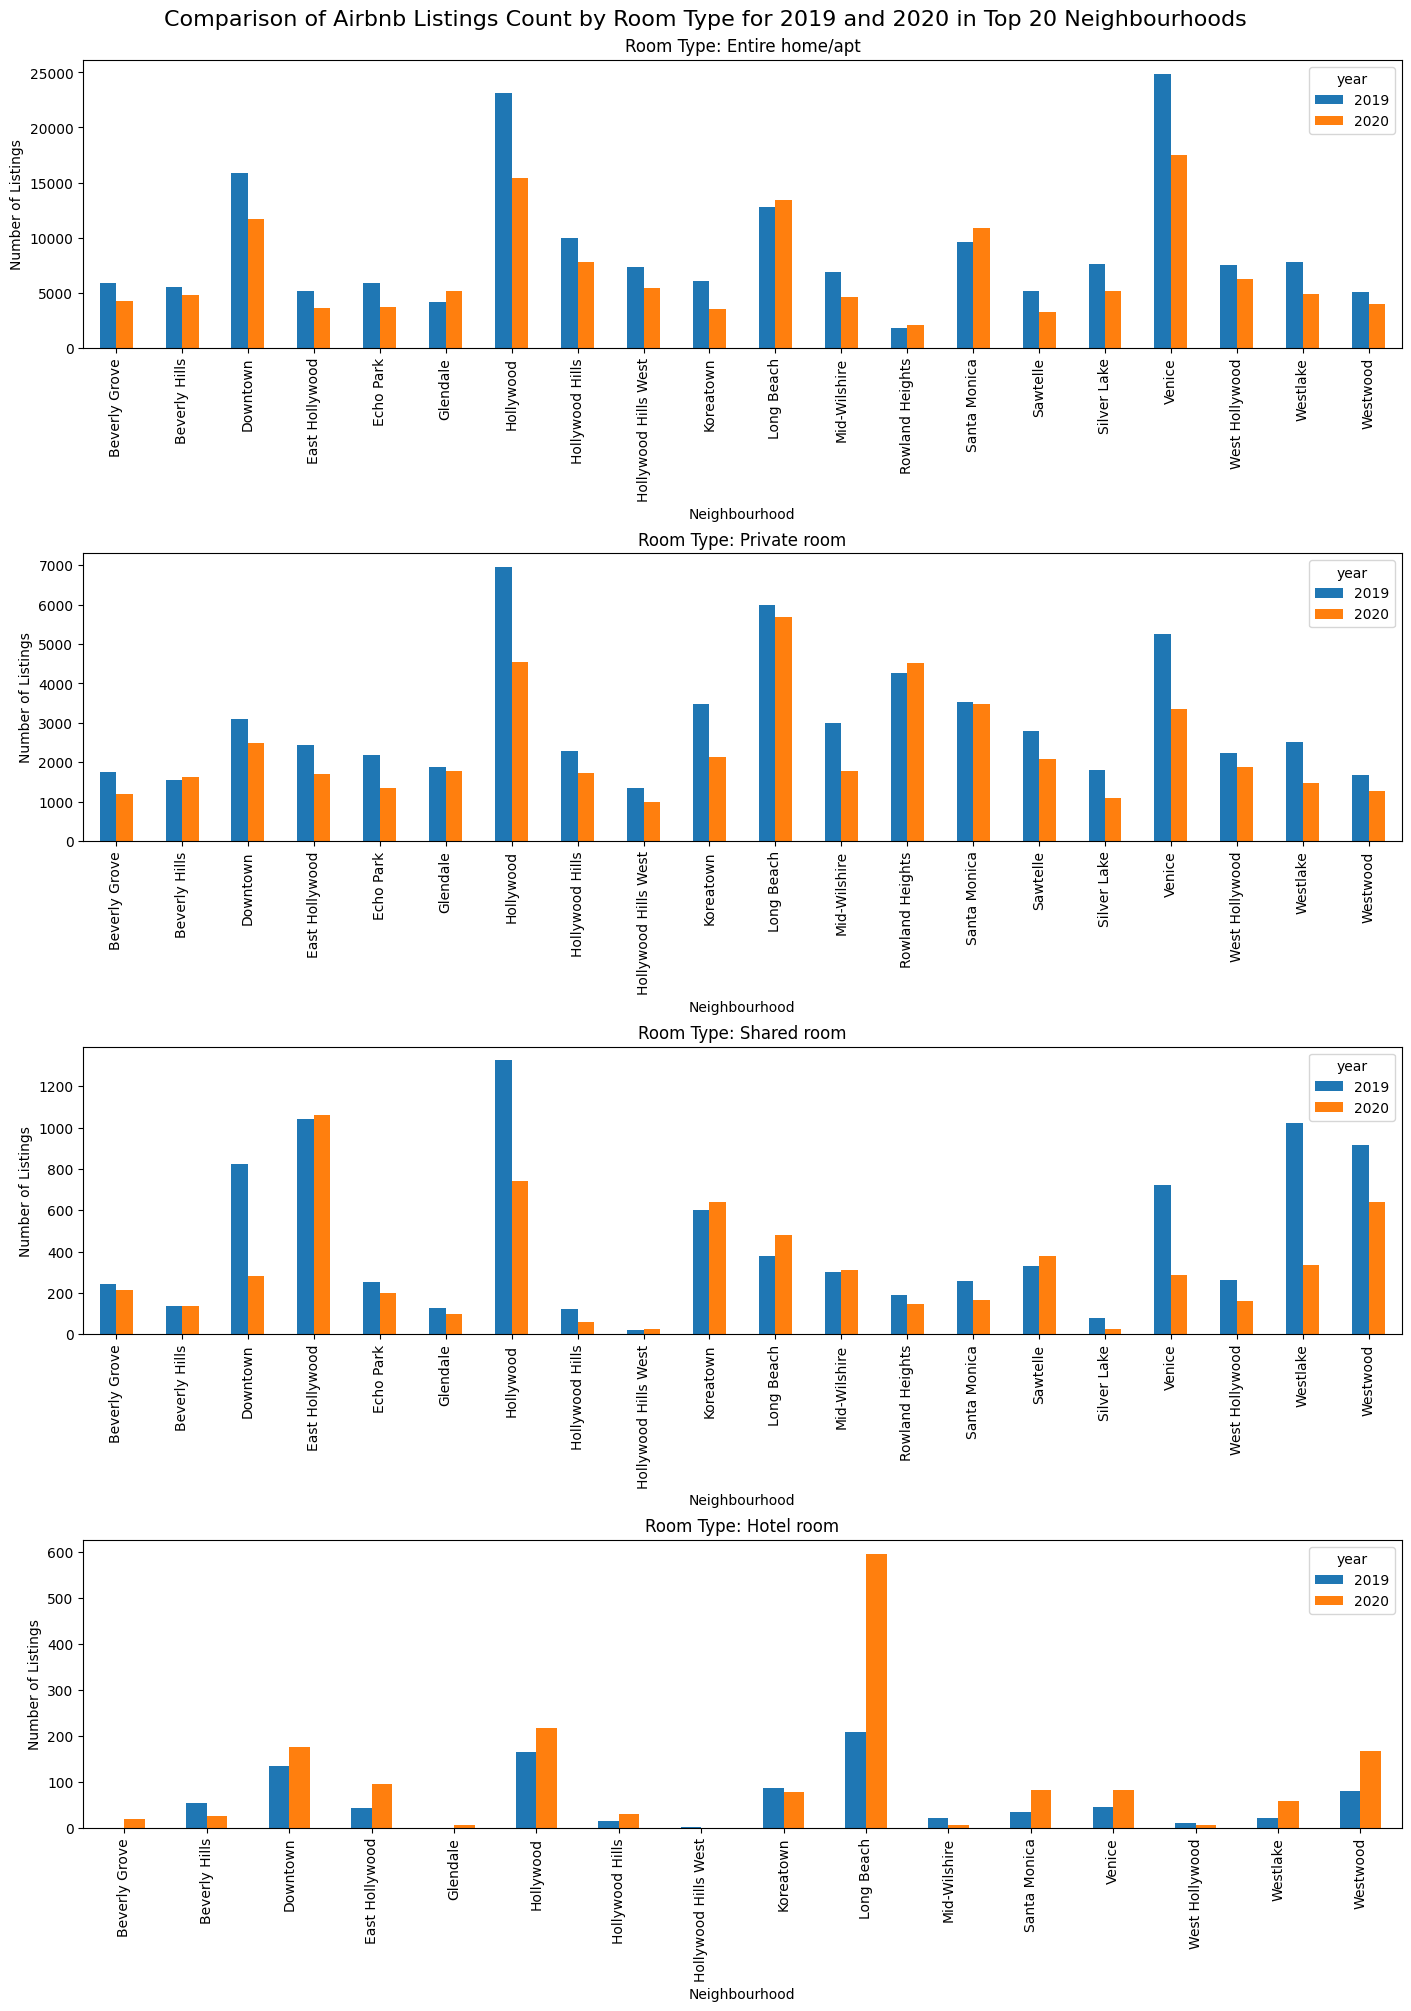

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import re

def visualize_top_listings_by_room_type(df, top_n=20):
    # Calculate the top neighbourhoods based on listing counts
    top_neighbourhoods = df['neighbourhood'].value_counts().head(top_n).index.tolist()

    # Filter the dataframe for the top neighbourhoods
    df_top_neighbourhoods = df[df['neighbourhood'].isin(top_neighbourhoods)]

    # Extracting year from the 'Scrape File' column
    df_top_neighbourhoods['year'] = df_top_neighbourhoods['Scrape File'].apply(lambda x: re.findall(r'\d{4}', x)[0])

    # Filter out the data for 2019 and 2020
    df_filtered = df_top_neighbourhoods[df_top_neighbourhoods['year'].isin(['2019', '2020'])]

    # Group by year, neighbourhood, and room type, then count the listings
    listings_count = df_filtered.groupby(['year', 'neighbourhood', 'room_type']).size().reset_index(name='count')

    # Get unique room types
    room_types = listings_count['room_type'].unique()

    # Create a subplot for each room type
    fig, axes = plt.subplots(nrows=len(room_types), ncols=1, figsize=(14, len(room_types) * 5), constrained_layout=True)

    for i, room_type in enumerate(room_types):
        # Filter the dataframe for the specific room type
        df_room = listings_count[listings_count['room_type'] == room_type]

        # Pivot the data for easy plotting
        pivot_table = df_room.pivot(index='neighbourhood', columns='year', values='count').fillna(0)

        # Plotting
        pivot_table.plot(kind='bar', ax=axes[i], title=f'Room Type: {room_type}')
        axes[i].set_ylabel('Number of Listings')
        axes[i].set_xlabel('Neighbourhood')

    # Overall title and show plot
    plt.suptitle('Comparison of Airbnb Listings Count by Room Type for 2019 and 2020 in Top 20 Neighbourhoods', fontsize=16)
    plt.show()

# Assuming df is your dataframe
visualize_top_listings_by_room_type(df)


**Entire Homes/Apartments**: For the most part, there appears to be a significant reduction in the number of entire homes and apartments listed on Airbnb in 2020 compared to 2019. This trend is noticeable across nearly all the neighbourhoods shown. The pandemic likely led to a decrease in travel, both for leisure and business, resulting in fewer people seeking entire places for their stays. Restrictions and lockdowns could have also caused property owners to withdraw from the market, either due to health concerns or due to a shift towards longer-term rentals outside the platform.

**Private Rooms**: The number of private rooms listed also decreased in 2020 for many neighbourhoods but to a lesser extent than entire homes/apartments. Some areas even saw a slight increase. This could suggest that while the demand for travel and accommodation declined, the market for private rooms didn't shrink as much, possibly due to a more budget-conscious traveller during the economic downturn caused by the pandemic, or locals seeking temporary housing solutions due to the pandemic's impact on their living situations.

**Shared Rooms**: The listings for shared rooms show a notable decrease in 2020 across most neighbourhoods. Given the nature of shared spaces and the increased risk of virus transmission, travellers and hosts alike may have been especially averse to such arrangements during the pandemic. The reduction in shared room listings is likely a direct response to social distancing guidelines and an increased focus on personal safety.

**Hotel Rooms**: While not as common as other types of Airbnb listings, hotel rooms also saw a decrease in 2020, which can be attributed to the overall decline in tourism and business travel. However, some neighbourhoods saw an increase in hotel room listings, which could be due to hotels offering rooms on Airbnb to compensate for the loss of traditional bookings through other channels.
